#  <u>Individual Report - Data Preperation and Preprocessing</u>

In [11]:
# import necessary libraries 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings

## Introduction

Data preparation is a major aspect of creating machine learning models. In order to ensure the most reliable results are produced raw data should be cleaned and prepared based on the context of data collection and domain factors. Below outlines the basic first steps of data preperation. 

In [3]:
# import csv and make dataframe 
df = pd.read_csv(r'C:\Users\User\Desktop\ADS1002 - NEM Project\Data_Updated_Data.txt')
df.head()

,Years,Months,Days,Hours,Minutes,Demand,Temperature,Time
0,2000,1,1,0,0,4511.3,-99999.9,2000-01-01 00:00:00
1,2000,1,1,0,30,4419.0,13.7,2000-01-01 00:30:00
2,2000,1,1,1,0,4312.5,13.6,2000-01-01 01:00:00
3,2000,1,1,1,30,4599.7,13.3,2000-01-01 01:30:00
4,2000,1,1,2,0,4479.0,14.1,2000-01-01 02:00:00


## Initial Cleaning and Preprocessing


First we import the required libraries and the dataframe. From the descriptive satistics we can see that the minimum values for 'Demand' and 'Temperature' are -99999.9, this seems illogical, and it is, these values are simply the empty cells recorded when the Automatic Weather System went down either for maintainence or system error. 

Since these values will severly negatively skew and bias our learning algorithm, it is reuqired that we remove them during data preparation. The simplest way to accomplish this is to turn -99999.9 values into NaN and then drop any rows with a NaN value.

In [4]:
# How many -99999.9 values? Automated counting
count = 0
for value in df['Temperature']:
    if value == -99999.9:
        count += 1
print("There are", count, " '-99999.9' values.")

There are 1283  '-99999.9' values.


Upon further investigation, we may observe that there are only 1283 unrecorded values, an insignificnt amount and as such safe to remove.

### Cleaning the data based on the steps outlined above

In [5]:
# Removing values which may neagtively imct our regression.
df.replace(to_replace=-99999.9, value=np.NaN,inplace= True)   # Replce -99999.9 values with NaN
df.dropna(axis = 0, how = 'any', thresh=None, subset=None, inplace=True,)   # Drop rows with NaN values
df.describe()   # Confirm dataframe changes

,Years,Months,Days,Hours,Minutes,Demand,Temperature
count,349349.000000,349349.00000,349349.000000,349349.000000,349349.000000,349349.000000,349349.000000
mean,2009.520176,6.52443,15.727908,11.500849,14.998411,5484.312176,15.903842
std,5.761403,3.44800,8.792967,6.924310,15.000021,886.655693,5.598543
min,2000.000000,1.00000,1.000000,0.000000,0.000000,2967.200000,0.800000
25%,2005.000000,4.00000,8.000000,5.000000,0.000000,4832.800000,12.000000
50%,2010.000000,7.00000,16.000000,12.000000,0.000000,5417.900000,15.100000
75%,2015.000000,10.00000,23.000000,18.000000,30.000000,6120.800000,19.000000
max,2019.000000,12.00000,31.000000,23.000000,30.000000,10414.900000,45.900000


Now we have a usable dataframe with only numbers.  

## Analysing The Context of The Data

Once we have a useable dataframe, we want to consider how to utilse that data to produce a learning algorithm. Understanding the basic necesisty of a training and testing set for machine learning we want to split our data into corresponding sections. 

However, there are some complications in this regard with our particular data set due to politial intervention around 2011.  The Gillard government had implemented a carbon tax, raising the price of fossil fuels, coal, natural gas, and petroleum products based on the carbon emissions of each fuel.

Coincidentally, 68.39% of the electricity in the National Electricity Market is fueled by coal, followed by 8.04% by gas and 7.53% by wind, (statistics for years 2019-20). Consequently, due to the carbon tax the price of electricity rose and as a result it was reported that the scheme had cut carbon emissions by as much as 17 million tonnes within the first year. Evidently the legislation will have long term impacts on demand, splitting our dataframe, where any point post 2011 will have a lower demand at a similar point pre 2011.

In [6]:
# Finding the average demands pre and post 2011
post2011_df = df.query('Years>2011')['Demand']
pre2011_df = df.query('Years<=2011')['Demand']
print('The average demand pre-carbon tax is', pre2011_df.mean(), 'whilst the average demand post-carbon tax is', post2011_df.mean(),
      '. A difference of 500 is almost one standard deviation and thus too much to ignore.')

The average demand pre-carbon tax is 5675.704349260517 whilst the average demand post-carbon tax is 5198.8292033378775 . A difference of 500 is almost one standard deviation and thus too much to ignore.


To account for this imbalance we decided to only use data from 2010 onwards, meaning we use only half the data set. Our group decided not to split it at 2011 as we wanted to use at least half of the given data and including a single year pre-carbon tax does not affect the afformentioned trend.

In [7]:
# Finding the average demands pre and post 2010 to show that the removal of our afformentioned trend remains even if we keep
# one extra year of data. 
post2010_df = df.query('Years>=2010')['Demand']
pre2010_df = df.query('Years<2010')['Demand']
a = post2011_df.mean()
b = pre2011_df.mean()
print('The average demand pre-2010 is', b, 'whilst the average demand post 2010 tax is', a)

The average demand pre-2010 is 5675.704349260517 whilst the average demand post 2010 tax is 5198.8292033378775


## How to Determine Training and Testing Data Sets
Here we want to split the data based on the year based criteria above, but also start to think about our training and testing sets. 

Our data is time sensitive due to the natural fluctuations of the seasons, if we use the "train test split" function we will not be able to obtain true representations of the data in each category beacuse it does not consider from which time frame it is extracting that data; thus, the learning algorithm will be biased. This reason is also why we required teh removal of data pre-2010 as it would train our model to over predict demand.

Hence, we have chosen data points pre 2019 as our traning set and have a year of data to test our model. 

In [8]:
trainingdf = df.query('2009 < Years < 2019') # Create the training dataframe
testingdf = df.query('Years >= 2019') # Create the testing dataframe 

## Preliminary Processing / EDA

### Accounting for Trends

With our dataset's organised we can begin some exploratry data analysis and preprocessing to prepare our data for modelling.

The first step is to create a time series plot to investigate for any long term trends. Although we have a variable labelled 'Time' it is not in date-time format, thus we cannot use it to plot just yet. Therefore, an additional processing step we must take is to convert 'Time' into date-time format.

In the below graph we are inspecting for a long term trend in the data we plan to use (2010 onwards), meaning the seasonal cycle of each year may remain. 

Text(0.5, 1.0, 'Time Series Plot of Demand from 2010 - 2019')

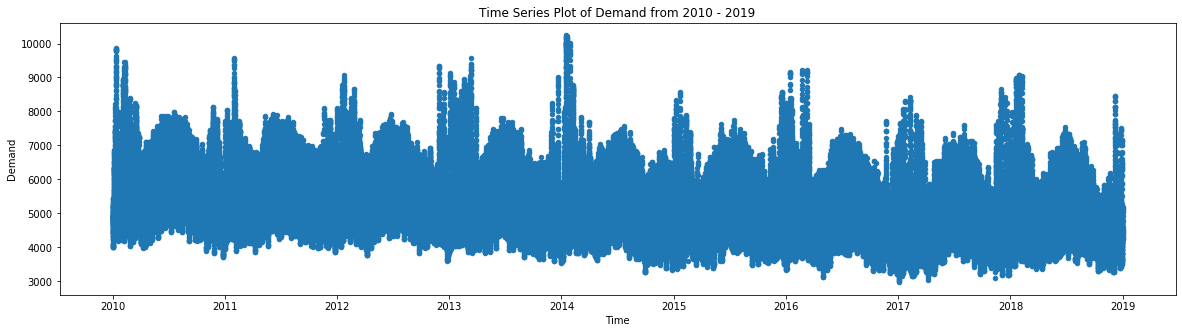

In [15]:
warnings.filterwarnings('ignore')
trainingdf['Time'] = pd.to_datetime(trainingdf['Time']) # Convert the time variable to date-time so we can plot
trainingdf.plot.scatter(x = 'Time', y = 'Demand', figsize=(20,5)) # Plot a time series graph
plt.title("Time Series Plot of Demand from 2010 - 2019")

Evidently, we can see a downward trend in our time series plot of the data we plan to use. 

In the context of electricity demand data there are several factors which influence it's long term trend in both directions. 

The most obvious, global warming, increasing the need for electricity to power coolers in the summer, or the fact that there has been a steady increase in Australia's population growth, meaning more households the NEM needs to supply. Additionally, there are business factors such as more and more large companies are being built which require electricity to power the day to day runnings, (increasing demand), and electronics becoming more and more power efficient, (reducing demand).

However, due to the obvious downward trend we can attribute it to more positive factors. For example a growing number of people are becoming more environmentally conscious, currently more than 17.9% of Victorian households now have rooftop solar systems (AVPI, 2019). 

It is necessary to remove these trends as it will bias the learning algorithm during the training phase and it produce inaccurate metrics during the testing phase.

The normalisation process can be automated using a for loop, or can be done manually by doing each year seperately. To clarify, thsi means 'manually' obtaining the mean of each year, not the normalised demand value, that part is always automated.

Below is an image of a normalised demand time series plot. Observe that we have rid the data of the longterm downward trend.

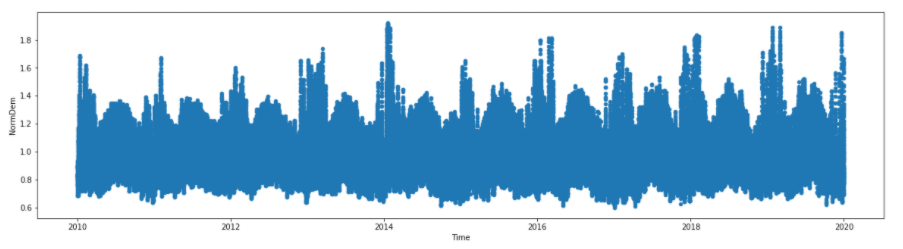

## Final Remarks
The above report details the importance of preprocessing and preparation in machine learning. To ensure a usable and unbiased model, clean and noramlised data is a necessity. 

At this point, the necessary steps and precautions have been taken to prepare the initial dataframe. All that needs to be done to finalise the dataframe for modelling is to calculate and add the additional variables discussed: day lag, week lag and day of the week.